In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
import os
import netron
from fastai import *
from fastai.tabular import *

os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

In [71]:
data = pd.read_csv("data/subset_csv.csv", header=0)
data = data.drop(["Unnamed: 0"], axis=1)

In [72]:
data = data.drop("0.1", axis=1)

In [73]:
data = data.fillna(0)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,403,404,405,406,407,408,409,410,411,412
0,Ambulance,4294.871795,4291.794872,4294.358974,4298.461538,4292.820513,4278.974359,4276.410256,4288.205128,4291.282051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Ambulance,4272.307692,4274.871795,4266.153846,4262.051282,4254.358974,4251.282051,4264.102564,4250.769231,4244.102564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Ambulance,4209.230769,4217.435897,4197.435897,4180.000000,4194.871795,4205.641026,4197.435897,4201.025641,4202.564103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ambulance,4287.692308,4294.358974,4312.820513,4309.743590,4288.717949,4295.384615,4313.846154,4301.538462,4288.717949,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Ambulance,4324.102564,4311.794872,4287.692308,4289.230769,4304.615385,4295.897436,4290.769231,4322.564103,4334.871795,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
data = data[data.columns[:392]]

In [75]:
classes = list(data["0"].unique())
classes

['Ambulance',
 'Flamingo',
 'Football',
 'Kite',
 'Mushroom',
 'Orange',
 'Stethescope',
 'Strawberry',
 'Toaster',
 'Zebra']

In [76]:
data.loc[0][0]

'Ambulance'

In [77]:
procs = [FillMissing, Categorify, Normalize]

valid_idx = range(len(data) - 50, len(data))

In [78]:
dep_var = "0"
cat_names = "0"

In [80]:
for a in cat_names:
    data[a] = data[a].astype("category").cat.codes

In [81]:
max_y = np.max(data.iloc[0].values[1::])
y_range = torch.tensor([0, max_y])

In [82]:
path = Path(".")

In [124]:
datab = TabularDataBunch.from_df(
    path, data, dep_var, valid_idx=valid_idx, procs=procs, classes=[x for x in range(10)],cont_names = data.columns[1::].values
)

In [125]:
datab.train_dl = datab.train_dl.new(shuffle=False)

In [135]:
class NewMod(Module):
    def __init__(
        self,
        emb_szs: ListSizes,
        n_cont: int,
        out_sz: int,
        layers: Collection[int],
        ps: Collection[float] = None,
        emb_drop: float = 0.0,
        y_range: OptRange = None,
        use_bn: bool = True,
        bn_final: bool = False,
    ):
        super().__init__()
        ps = ifnone(ps, [0] * len(layers))
        ps = listify(ps, layers)
        self.embeds = nn.ModuleList([embedding(ni, nf) for ni, nf in emb_szs])
        self.emb_drop = nn.Dropout(emb_drop)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb, self.n_cont, self.y_range = n_emb, n_cont, y_range
        sizes = self.get_sizes(layers, out_sz)

        self.num_classes = 10
        self.num_layers = 10
        self.input_size = 391
        self.hidden_size = 256
        self.seq_length = 128

        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True,
        )

        self.fc = nn.Linear(self.hidden_size, self.num_classes)

    def get_sizes(self, layers, out_sz):
        return [self.n_emb + self.n_cont] + layers + [out_sz]

    def forward(self, x_cat: Tensor, x_cont: Tensor) -> Tensor:
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont

        x = torch.unsqueeze(x, 0)

        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(
            "cuda"
        )

        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(
            "cuda"
        )
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)


        return x

In [136]:
model = NewMod(
    n_cont=len(datab.cont_names),
    out_sz=datab.c,
    layers=[1000, 200, 15],
    emb_drop=0.1,
    emb_szs={(0, 0)},
)

In [137]:
learn = None
gc.collect()

7403

In [138]:
from torch.optim import *
from fastai.vision import *

In [139]:
learn = Learner(
    datab, model, metrics=accuracy, callback_fns=ShowGraph, opt_func=AdamW
)

In [140]:
learn.model

NewMod(
  (embeds): ModuleList(
    (0): Embedding(0, 0)
  )
  (emb_drop): Dropout(p=0.1, inplace=False)
  (bn_cont): BatchNorm1d(391, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(391, 256, num_layers=10, batch_first=True)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)

In [141]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

Exception ignored in: <function _releaseLock at 0x7fcad2580ef0>
Traceback (most recent call last):
  File "/home/subhaditya/anaconda3/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: DataLoader worker (pid(s) 16507, 16508, 16509, 16510, 16511, 16512, 16513, 16514) exited unexpectedly

epoch,train_loss,valid_loss,accuracy,time
0,6.259534,6.123714,0.000000,00:00
1,6.258601,6.114785,0.000000,00:00
2,6.257661,6.107714,0.000000,00:00
3,6.256707,6.102067,0.000000,00:00
4,6.255734,6.097531,0.000000,00:00
5,6.254738,6.093854,0.000000,00:00
6,6.253718,6.090855,0.000000,00:00
7,6.252668,6.088393,0.000000,00:00
8,6.251588,6.086351,0.000000,00:00
9,6.250473,6.084645,0.000000,00:00


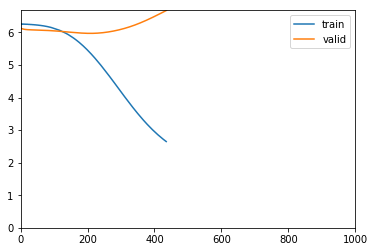

Exception ignored in: <function _releaseLock at 0x7fcad2580ef0>
Traceback (most recent call last):
  File "/home/subhaditya/anaconda3/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


RuntimeError: DataLoader worker (pid(s) 15790, 15791, 15792, 15793, 15794, 15795, 15796, 15797, 15798) exited unexpectedly

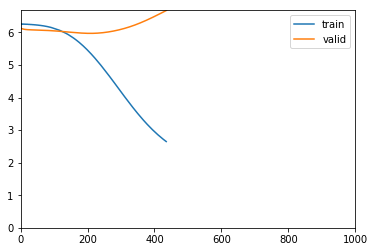

In [134]:
learn.unfreeze()
learn.fit_one_cycle(500, 1e-2, wd=1e-3)

In [142]:
get_transforms??

Signature:
get_transforms(
    do_flip: bool = True,
    flip_vert: bool = False,
    max_rotate: float = 10.0,
    max_zoom: float = 1.1,
    max_lighting: float = 0.2,
    max_warp: float = 0.2,
    p_affine: float = 0.75,
    p_lighting: float = 0.75,
    xtra_tfms: Union[Collection[fastai.vision.image.Transform], NoneType] = None,
) -> Collection[fastai.vision.image.Transform]
Source:   
def get_transforms(do_flip:bool=True, flip_vert:bool=False, max_rotate:float=10., max_zoom:float=1.1,
                   max_lighting:float=0.2, max_warp:float=0.2, p_affine:float=0.75,
                   p_lighting:float=0.75, xtra_tfms:Optional[Collection[Transform]]=None)->Collection[Transform]:
    "Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms."
    res = [rand_crop()]
    if do_flip:    res.append(dihedral_affine() if flip_vert else flip_lr(p=0.5))
    if max_warp:   res.append(symmetric_warp(magnitude=(-max_warp,max_warp), p=p_affine))
    if max_rot